# Project | Natural Language Processing Challenge
### Fake news classifier

Environment

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import nltk
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rache\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load train and test data


In [ ]:
# 1. Loading the training dataset
# We use '\t' as the separator because the file is in TSV (Tab-Separated Values) format.
# Since the raw file lacks a header row, we manually assign column names: 'label' and 'text'.
train_data_raw = pd.read_csv(
    "../data/training_data_lowercase.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

# 2. Loading the unlabeled test dataset for the challenge
# This file will be used for final predictions. 
# It follows the same structure as the training data but labels are placeholders (usually '2').
test_data_raw = pd.read_csv(
    "../data/testing_data_lowercase_nolabels.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

quick EDA

In [14]:
# preview
display(train_data_raw.head())

# shapes
print(
    f"Training data shape (rows, columns): {train_data_raw.shape}\n"
    f"Test data shape (rows, columns): {test_data_raw.shape}"
)


# fake news / real news balance
print("\nFake news / real news balance:")
print(train_data_raw["label"].value_counts(normalize=True))

# missing values
print("\nMissing values per column:")
print(train_data_raw.isnull().sum())

# empty text check
empty_texts = (train_data_raw["text"].str.strip() == "").sum()
print(f"\nNumber of empty text entries: {empty_texts}")


,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


Training data shape (rows, columns): (34152, 2)
Test data shape (rows, columns): (9984, 2)

Fake news / real news balance:
label
0    0.514523
1    0.485477
Name: proportion, dtype: float64

Missing values per column:
label    0
text     0
dtype: int64

Number of empty text entries: 0


Training - validation split

In [ ]:
# 1. Separate the features (X) and the target labels (y)
X = train_data_raw["text"]
y = train_data_raw["label"]

# 2. Split the dataset into Training and Testing sets
# test_size=0.2: 20% of the data is reserved for testing, 80% for training
# random_state=42: Ensures reproducibility of the split
# stratify=y: Maintains the same class distribution (ratio of fake vs real news) 
# in both the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Data cleaning

In [ ]:
# Function to normalize text by removing special characters and extra whitespace
def clean_text(text):
    # Use Regular Expression (re) to keep only lowercase letters (a-z) and spaces
    text = re.sub(r"[^a-z\s]", " ", text)
    # Collapse multiple spaces into a single space and trim leading/trailing whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply the preprocessing function to the training and testing datasets
X_train_clean = X_train.apply(clean_text)
X_test_clean  = X_test.apply(clean_text)

vectorization word2vec 
Word Embeddings vectorization

In [17]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# 1. Tokenization Process
# Word2Vec requires a list of tokens (individual words) rather than raw strings.
# We split the cleaned sentences; 'str' conversion is used to handle potential 
# missing values (NaN) or numeric entries, ensuring robust input for the model.
train_tokens = [str(text).split() for text in X_train_clean]
test_tokens  = [str(text).split() for text in X_test_clean]

# 2. Training the Word2Vec Model
# vector_size=100: Each word is mapped to a 100-dimensional dense vector space.
# window=5: The maximum distance between the current and predicted word within a sentence.
# min_count=1: Ensures all words are represented, regardless of their frequency.
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

print("Word2Vec vectorization model trained successfully!")

# 3. Sentence Embedding via Vector Aggregation (Mean Pooling)
# This function calculates the average of all word vectors in a sentence 
# to generate a fixed-size feature vector for downstream classification.
def get_sentence_vector(tokens, model):
    # Retrieve embeddings for words present in the trained vocabulary
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        # Returns a zero vector if the sentence contains no known words
        return np.zeros(100) 
    return np.mean(vectors, axis=0)

# 4. Feature Matrix Construction
# Transform token lists into numerical matrices (X_train_w2v, X_test_w2v).
# These arrays serve as standardized input for both CPU and GPU-based classifiers.
X_train_w2v = np.array([get_sentence_vector(t, w2v_model) for t in train_tokens])
X_test_w2v  = np.array([get_sentence_vector(t, w2v_model) for t in test_tokens])

print("Data successfully vectorized and ready for model training (CPU or GPU)!")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Word2Vec vectorization model trained successfully!
Data successfully vectorized and ready for model training (CPU or GPU)!


In [19]:
!pip install xgboost

Model training xgboost

In [ ]:
from xgboost import XGBClassifier
import torch

# 1. New way to detect GPU for XGBoost 2.0+
# In newer versions, we use 'cuda' instead of 'gpu_hist'
if torch.cuda.is_available():
    device_method = 'cuda' 
    print("GPU detected! Using 'cuda' for high-speed training.")
else:
    device_method = 'hist'
    print("no GPU found. Using 'hist' on CPU.")

# 2. Initializing XGBoost
model = XGBClassifier(
    device=device_method, 
    n_estimators=200,     # Plus d'arbres
    learning_rate=0.02,    # Plus lent mais plus précis
    max_depth=7,           # Plus profond
    random_state=42
)

# 3. Training
model.fit(X_train_w2v, y_train)

# 4. Accuracy
accuracy = model.score(X_test_w2v, y_test)
print(f" Training complete! My estimated accuracy: {accuracy * 100:.2f}%")

🚀 GPU detected! Using 'cuda' for high-speed training.
✅ Training complete! My estimated accuracy: 90.57%


the final validation result for xgboost 

In [ ]:
import pandas as pd
import numpy as np

# 1. Load the unlabeled dataset provided for the challenge
# This file contains the '2' labels that we need to predict
final_val_df = pd.read_csv("../data/testing_data_lowercase_nolabels.csv", sep='\t', header=None)

# 2. Text Preprocessing & Vectorization
# We apply the same cleaning function used during training to ensure consistency
print("Step 1: Cleaning validation text")
val_texts_cleaned = final_val_df[1].apply(clean_text)

# Convert sentences into lists of tokens (words) for Word2Vec processing
val_tokens = [str(t).split() for t in val_texts_cleaned]

# Transform tokens into numerical vectors using the pre-trained Word2Vec model
print("Step 2: Vectorizing with Word2Vec")
X_final_val_w2v = np.array([get_sentence_vector(t, w2v_model) for t in val_tokens])

# 3. Model Inference
# Using the trained XGBoost model to predict labels on the validation set
print("Step 3: Running XGBoost prediction")
final_predictions = model.predict(X_final_val_w2v)

# 4. Final Formatting
# Update the first column (placeholder '2') with our model's predictions (0 or 1)
final_val_df[0] = final_predictions

# 5. Export results
# Save the output as a tab-separated file without headers or index, as per challenge requirements
final_val_df.to_csv("validation_results_xgboost2.csv", sep='\t', index=False, header=False)

print("The file 'validation_results_xgboost2.csv' has been generated. This is the final submission file.")

Step 1: Cleaning validation text
Step 2: Vectorizing with Word2Vec
Step 3: Running XGBoost prediction
The file 'validation_results_xgboost2.csv' has been generated, that's the final file.


In [ ]:
# Accuracy on the data the model was trained on (Training Set)
xgb_train_acc = model.score(X_train_w2v, y_train)

# Accuracy on the unseen data (Testing Set)
xgb_test_acc = model.score(X_test_w2v, y_test)

print(f"--- XGBoost (Word2Vec) ---")
print(f"Training Accuracy: {xgb_train_acc * 100:.2f}%")
print(f"Testing Accuracy: {xgb_test_acc * 100:.2f}%")

--- XGBoost (Word2Vec) ---
Training Accuracy: 93.63%
Testing Accuracy: 90.57%


<Figure size 800x600 with 0 Axes>

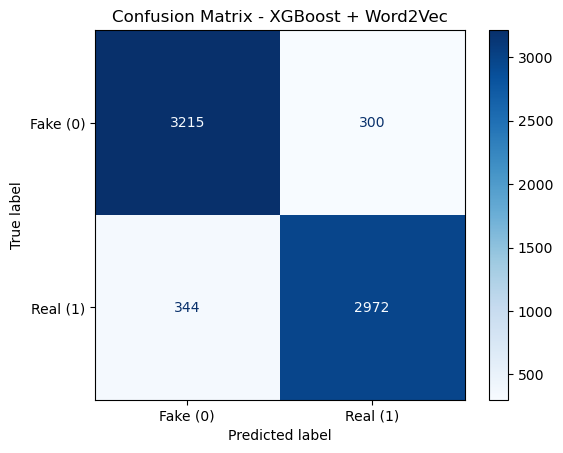

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Obtain predictions on the test set
y_pred = model.predict(X_test_w2v)

# 2. Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Display the matrix with a heatmap
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake (0)', 'Real (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost + Word2Vec")
plt.show()